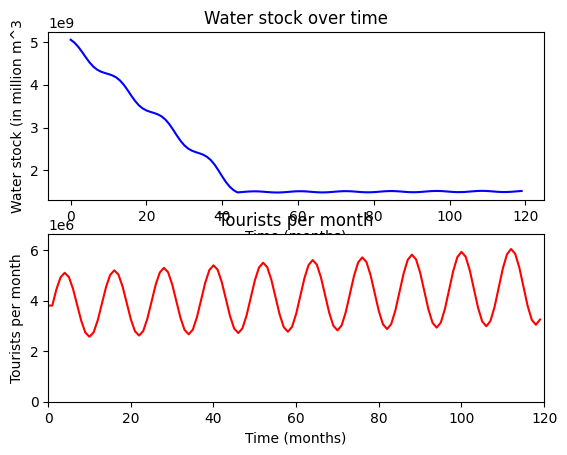

In [4]:
# -- coding: utf-8 --
"""
Created on Sat Dec  7 22:00:35 2024

@author: meesvandersmagt
"""

# importing neccesary packages
import math as m
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# specify time steps
dt = 1  # in months (begins in spring)
endtime = 120  # amount of months simulated

# here you can set at which month water taken from the lake will be adjusted
# 1 means 100%
change_month = 44
rel_wateruse_before = 1
rel_wateruse_after = 0.1  # this has been used in calibration phase

timelist = list(range(0, endtime, dt))
nr = len(timelist)


# %% defining variables

init_waterstock = 5050150000  # initial volume of lake, in m^3
max_waterstock = 5130000000  # maximum volume of lake, in m^3


def mm_to_m3(height):
    """
    Calculates mm of water into m^3

    Input: height in mm
    Output: volume in m^3

    in order to combine different sets of data, we need to be able to compare
    water measured in mm (eg precipitation) and m^3 (eg household wateruse)
    For this we use the lake surface in m^2
    """
    height_in_m = height / 1000
    volume = height_in_m * lake_surface
    return volume


avg_evap = 30 * 3.25  # yearly average of water evaporating from lake, mm/month
fluc_evap_ratio = 0.77
lake_surface = 57000000  # total area of lago bracciano in m^2
avg_evap = mm_to_m3(avg_evap)  # calculating mm -> m^3 per month

avg_precip = 85.7  # yearly average of precipitation per month in mm
fluc_precip_ratio = -0.6418  # amplitude of seasonal flux of precipitation, mm
avg_precip = mm_to_m3(avg_precip)  # mm -> m^3
# montly inflow into lake of groundwater, m^3, rough estimation (calibration)
ground_water = 850000


w_leakage = 0.3  # percentage of water leaking from inflow pipes
# water inflow into the city from other sources than lake bracciano (aquaducts)
avg_river_in = 59655600 * (1 - w_leakage)  # in m^3 per month


# later goal: specify tourists per sector

inhabitants = 4.4 * 10 ** 6  # inhabitants in the region of Lazio
avg_wateruse_pipd = 312.3  # average wateruse per inhabitant per day, in L/day
avg_wateruse_pipd = 30 * avg_wateruse_pipd / 1000  # L / day -> m3 / month


init_avg_tourists = 3810597  # total tourist nights spent in Rome per month
fluc_tourists_ratio = 0.3344  # amplitude of seasonal fluctuations in tourists
avg_wateruse_ptpd = 150  # average wateruse per tourist per day, in L
avg_wateruse_ptpm = 30 * avg_wateruse_ptpd / 1000000000  # L -> m3
tourist_annual_gr = 1.019  # yearly growth rate of tourist nights spent
tourist_month_gr = tourist_annual_gr ** (1/12)  # yearly -> monthly
    
"""
it's very hard to find data on wateruse for industry/agriculture. we have
estimated this number in calibration fase
"""
other_wateruse = 4000000  # m^3 / month (calibration)


# %% flow functions

list_tourists = [0] * nr
list_tourists[0] = init_avg_tourists


def tourist_amt(month):
    """
    Calculating amount of toursits per month based on seasonal fluctuations

    Input: month index (or modulo 12)
    Output: number of tourist nights spent current month

    Instead of using real data per month which is hard to find for some regions
    we have opted to estimate this number based on yearly averages for the
    sake of generality of the model

    """
    seasonal = m.sin(month / 12 * 2 * m.pi)
    avg_tourists = init_avg_tourists * tourist_month_gr ** month
    fluc_tourists = avg_tourists * fluc_tourists_ratio
    amt_tourists = avg_tourists + seasonal * fluc_tourists
    list_tourists[month+1] = amt_tourists
    return amt_tourists * 2  # tourists per month


def total_outflow(month, human_factor=1, nature_factor=1):
    """
    Calculating the city water use and water outflow of the reservoir

    Inputs:
    month : month index (or modulo 12)
    human_factor : factor of human use being calculated (1 is 100%)
    nature_factor : factor of evaporation being calculated (1 is 100%)

    Output: amount of water in m^3

    The monthly evaporation is being calculated based on yearly averages and
    the seasonal fluctuations.
    If nature_factor is set to 0 this function calculates the total water
    demand of the region.
    The human_factor can be used to adjust the percentage of water taken from
    the lake of the total water needed by the region
    """
    seasonal = m.sin(month / 12 * 2 * m.pi)
    fluc_evap = avg_evap * fluc_evap_ratio
    evap = avg_evap + seasonal * fluc_evap
    amt_tourists = tourist_amt(month)
    tourist_use = amt_tourists * avg_wateruse_ptpm
    inhab_use = avg_wateruse_pipd * inhabitants
    human_use = inhab_use + tourist_use + other_wateruse
    return evap * nature_factor + human_use * human_factor


def total_inflow(month):
    """
    Calculating the water inflow into the reservoir

    Input: month index (or modulo 12)
    Output: amount of water inflow per month in m^3

    Instead of using real data per month which is hard to find for some regions
    we have opted to estimate this number based on yearly averages for the
    sake of generality of the model
    """
    seasonal = m.sin(month / 12 * 2 * m.pi)
    fluc_precip = avg_precip * fluc_precip_ratio
    amt_precip = avg_precip + seasonal * fluc_precip + ground_water
    return amt_precip


# %% calculating water stock

list_waterst = [0] * nr
list_waterst[0] = init_waterstock

for i in range(0, nr-1):
    # calculating city water demand in m^3
    w_used = total_outflow(i, rel_wateruse_before, 0)
    w_inflow = total_inflow(i)

    # calculating amt of water demand higher than stable water inflow
    overuse = w_used - avg_river_in

    # if no overuse, there's no water extracted from lake for human use
    if overuse <= 0:
        w_outflow = total_outflow(i, 0)
        cur_waterst = list_waterst[i] + w_inflow - w_outflow

    # if there is overuse, calculate amt water extracted (before stopping)
    elif i < change_month:
        w_outflow = total_outflow(i) - avg_river_in
        cur_waterst = list_waterst[i] + w_inflow - w_outflow
        if w_outflow < 0:
            print("HELP")

    # after stopping water extraction (only in emergencies)
    else:
        w_used = total_outflow(i, rel_wateruse_after, 0)
        overuse = w_used - avg_river_in
        if overuse <= 0:
            w_outflow = total_outflow(i, 0)
            cur_waterst = list_waterst[i] + w_inflow - w_outflow
        else:
            w_outflow = total_outflow(i, rel_wateruse_after) - avg_river_in
            cur_waterst = list_waterst[i] + w_inflow - w_outflow

    # if water level gets too high, overflow to river gets active
    if cur_waterst > max_waterstock:
        cur_waterst > max_waterstock

    list_waterst[i+1] = cur_waterst


# %% making graphs

months = np.arange(0, nr)

plt.figure()
plt.subplot(211)
plt.plot(months, list_waterst, 'b-')
plt.xlabel('Time (months)')
plt.ylabel('Water stock (in million m^3')
plt.title('Water stock over time')

plt.subplot(212)
plt.plot(months, list_tourists, 'r-')
plt.axis((0, endtime, 0, max(list_tourists) * 1.1))
plt.xlabel('Time (months)')
plt.ylabel('Tourists per month')
plt.title('Tourists per month')
plt.show()


# %% exporting to csv

ls = list_waterst

df = pd.DataFrame(ls)
df.to_csv("simwaterdata.csv", index=False, header=False)